# Notebook 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/neurosymbolic_notebook1.ipynb)

## Instructions

**README** 

* **Navigating this notebook on Google Colab:** There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code.  Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing `control/cmd + enter` or by clicking the arrow on left-hand side as shown.
    ![img.png](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/imgs/guide.png?raw=true)

* **Saving Work**: If you wish to save your work in this `.ipynb`, we recommend [downloading](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/tree/popl23) the compressed repository from GitHub, unzipping it, uploading it to Google Drive, opening this notebook from within Google Drive, and setting `WITHIN_GDRIVE` to `True`.


In [ ]:
# (Optional) Are you loading data from within Google Drive?
WITHIN_GDRIVE = False # otherwise: True

In [ ]:
# Setup repository and download toy CalMS21 data
if not WITHIN_GDRIVE:
  !git clone https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial.git /content/Neurosymbolic_Tutorial
  %cd /content/Neurosymbolic_Tutorial/code_and_data
  !gdown 1XPUF4n5iWhQw8v1ujAqDpFefJUVEoT4L && (unzip -o calms21_task1.zip; rm -rf calms21_task1.zip )
else:
  from google.colab import drive
  drive.mount('/content/drive')
  # Change this path to match the corect destination
  %cd /content/drive/MyDrive/Neurosymbolic_Tutorial/code_and_data/
  import os; assert os.path.exists("dsl.py"), f"Couldn't find `dsl.py` at this location {os.getcwd()}. HINT: Are you within `code_and_data`"
  !gdown 1XPUF4n5iWhQw8v1ujAqDpFefJUVEoT4L && (unzip -o calms21_task1.zip; rm -rf calms21_task1.zip )


import os
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Neurosymbolic_Tutorial/code_and_data
Downloading...
From: https://drive.google.com/uc?id=1XPUF4n5iWhQw8v1ujAqDpFefJUVEoT4L
To: /content/drive/MyDrive/Neurosymbolic_Tutorial/code_and_data/calms21_task1.zip
100% 18.2M/18.2M [00:00<00:00, 121MB/s] 
Archive:  calms21_task1.zip
   creating: data/
   creating: data/calms21_task1/
  inflating: data/calms21_task1/test_data.npy  
  inflating: data/calms21_task1/test_investigation_labels.npy  
  inflating: data/calms21_task1/test_mount_labels.npy  
  inflating: data/calms21_task1/test_trajectory_data.npy  
  inflating: data/calms21_task1/train_data.npy  
  inflating: data/calms21_task1/train_investigation_labels.npy  
  inflating: data/calms21_task1/train_mount_labels.npy  
  inflating: data/calms21_task1/train_trajectory_data.npy  
  inflating: data/calms21_task1/val_data.npy  
  inflating: data

# Data Exploration and Visualization

We will explore neurosymbolic models using a behavior analysis dataset. This dataset is a subset of [the Caltech Mouse Social Interactions Dataset (CalMS21)](https://https://arxiv.org/pdf/2104.02710.pdf). Neuroscientist study animal interactions to better understand the relationship between brain and behavior (see [MARS](https://elifesciences.org/articles/63720), [quantifying behavior review](https://www.nature.com/articles/s41593-020-00734-z), [decoding behavior article](https://www.quantamagazine.org/to-decode-the-brain-scientists-automate-the-study-of-behavior-20191210/)). Our goal is to map trajectory data (keypoints from two mice stacked over time `2 (mice) x 2 (x,y position) x 7 (7 keypoints per mice)`) to behaviors of interest identified by neuroscientists. The dataset consists of a pair of mice at each frame, the resident mouse in its home cage and the intruder mouse introduced to the cage.

![content_task1_structure.png](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/imgs/mabeOverview.png?raw=true)

The original dataset consists of over 3 million frames of annotations, with over 10 annotated behaviors. Fully neural models are benchmarked during the [the Multi-Agent Behavior Challenge](https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications) which took place in 2021 in conjunction with CVPR. We use a simplified and smaller version of the dataset for this tutorial (`5000 clips x 13 frames` with one annotated behavior of `investigation`, as well as `18` pre-computed features per frame, based on features identified by behavioral neuroscientists), but if you are interested in the full Multi-Agent Behavior challenge, the evaluator at the challenge link is open and available for the full dataset.Here, the `investigation` labels are class 1 and all other behaviors are class 0.

Final note is that instead of doing predictions sequence-by-sequence (temporal segmentation) as in the original CalMS21 dataset, here we will predict sequence-to-one labels, where we map `13` frames of trajectory data to a single human-annotated label corresponding to the behavior in the middle frame.

In [2]:
import numpy as np

# Original mouse trajectory data in x,y coordinates
trajectory_data = np.load("data/calms21_task1/train_trajectory_data.npy")
print("Trajectory data: " + str(trajectory_data.shape))

# Processed features from trajectory data, consisting of behavior attributes
# such as speed, facing angle, distance between mice, etc.
feature_data = np.load("data/calms21_task1/train_data.npy")
print("Extracted features: " + str(feature_data.shape))

# Human annotated labels 
labels = np.load("data/calms21_task1/train_investigation_labels.npy")
print("Label data: " + str(labels.shape))

Trajectory data: (5000, 13, 2, 2, 7)
Extracted features: (5000, 13, 18)
Label data: (5000, 1)


**Optional Exercise**: What is the proportion of clips that are annotated with investigation vs no investigation in the train set?

In [3]:
# Your implementation here.

## Plotting utility functions

These are utility functions to help with plotting, and no modifications are needed.

In [4]:
# Plotting utility functions.
 
rc('animation', html='jshtml')
  
#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570
 
RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'
 
PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
  
def set_figax():
    fig = plt.figure(figsize=(6, 4))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, keypoint_sequence):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(keypoint_sequence.shape[0]):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
         
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j), fontsize = 14)
 
        ax.axis('off')
        fig.tight_layout(pad=1)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani
 

## Plot a trajectory sample that is not annotated with investigation

This corresponds to a sample in class 0.



Processing frame  0


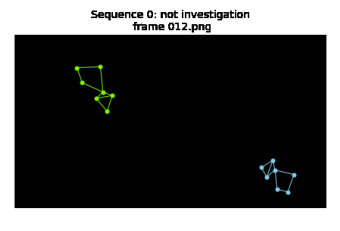

In [5]:
# Plot the first example of class 0 = not investigation

total_samples = labels.shape[0]

for i in range(total_samples):
  if labels[i] == 0:
    ani = animate_pose_sequence('Sequence ' + str(i) + ': not investigation', trajectory_data[i])
    break
ani

## Plot a trajectory sample that is annotated with investigation

This corresponds to a sample in class 1.

Processing frame  0


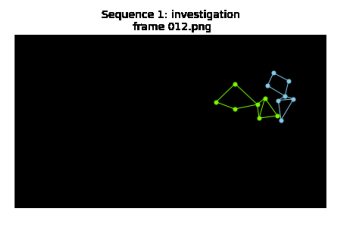

In [6]:
# Plot the first example of class 1 = investigation

for i in range(total_samples):
  if labels[i] == 1:
    ani = animate_pose_sequence('Sequence ' + str(i) + ': investigation', trajectory_data[i])
    break
ani

## Plot examples with feature values

In behavior analysis (similar to other fields of science), we often already have existing domain knowledge available. Here, we use existing features designed by neuroscientists for studying behavior (see [Mouse Action Recognition System](https://elifesciences.org/articles/63720)) instead of the raw trajectory data. These manually-designed features can be used as inputs to neural networks or as part of a Domain-Specific Language (more on this below).

In [7]:
# Feature value plotting utilities

def set_figax_features():
    fig = plt.figure(figsize=(6,6))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(211)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    ax2 = fig.add_subplot(212)

    return fig, ax, ax2

def animate_pose_sequence_features(video_name, keypoint_sequence, feature_sequence,
                                   max_y_lim = None, min_y_lim = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(keypoint_sequence.shape[0]):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax, ax2 = set_figax_features()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
         
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j), fontsize = 14)
 
        ax.axis('off')
        fig.tight_layout(pad=1)
        ax.margins(0)

        ax2.plot(np.arange(feature_sequence.shape[0]), feature_sequence)
        ax2.set_ylim([min_y_lim, max_y_lim])

        ax2.vlines(x = j, ymin = -100, ymax = 100,
                  colors = 'salmon', linestyles = 'dashed')

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    plt.tight_layout()
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani


**Exercise**: Modify the code below to plot some other samples and features - note that some feature subsets have more than one feature (ex: axis ratio has 2 features for the ratio between the long and short axis of the body for the resident and intruder mouse respectively). Is there a feature that can more easily distinguish between `not investigation` and `investigation`?

Processing frame  0


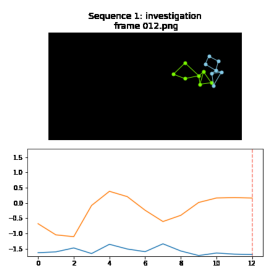

In [8]:
from IPython.display import HTML, Image # For GIF


# Plot the first example of class 1 = investigation with features
# Note that feature values are already normalized
CALMS21_FEATURE_SUBSETS = {
    "res_angle_head_body": np.arange(0, 2),
    "axis_ratio": np.arange(2, 4),
    "speed": np.arange(4, 6),
    "acceleration": np.arange(6, 8),
    "tangential_velocity": np.arange(8, 10),
    "rel_angle_social": np.arange(10, 12),
    "angle_between": np.arange(12, 13),
    "facing_angle": np.arange(13, 15),
    "overlap_bboxes": np.arange(15, 16),
    "area_ellipse_ratio": np.arange(16, 17),
    "min_res_nose_dist": np.arange(17, 18)
}

# Change the feature name in the dictionary here to plot different features.
feature_indices = CALMS21_FEATURE_SUBSETS['rel_angle_social'].squeeze()

# Modify the code below to plot different samples.
for i in range(total_samples):
  if labels[i] == 1:
    ani = animate_pose_sequence_features('Sequence ' + str(i) + ': investigation', 
                                         trajectory_data[i], 
                                         feature_data[i, :, feature_indices].transpose(),
                                         max_y_lim = np.max(feature_data[:, :, feature_indices]),
                                         min_y_lim = np.min(feature_data[:, :, feature_indices]))
    break

ani

# Neural Network Example (1D Conv Net)

One common way to train a neural network for sequence-to-one predictions is by using a 1D convolutional network (across the temporal dimension). We use the [Conv1D](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) implementation in Pytorch, within the Pytorch Lightning framework (a wrapper on top of Pytorch to simplify the code for training and data loading). Try going through the code below to familiarize yourself with training the 1D conv net below to get performance values of fully neural models on this dataset.

![neurosym-model-arch.png](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/imgs/cnnOverview.png?raw=true)

Important setups for the neural network training:
*   `TrainConfig`: defines hyperparameters for training
*   `Calms21Task1Dataset` and `Calms21Task1DataModule`: contains train, validation, and test dataloaders for training and evaluation. The dataloader outputs batched data for mini batch gradient descent.
*   `ConvNet1DBaseline`: defines the model architecture (1D Conv Net) with network weights updated during training using the Adam optimizer.

In [9]:
!pip install pytorch-lightning # Pytorch lightning is a wrapper around PyTorch.
import os
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import f1_score, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The two cells below contain code to set up the training config and the data loader for the CalMS21 dataset.

In [10]:
# Feel free to play around with these numbers at any time. Here's how to modify the numbers
# config = TrainConfig()
# config.epochs = 100 
class TrainConfig:
    epochs: int = 20
    batch_size: int = 32
    lr: float = 3e-3
    weight_decay: float = 0.0
    train_size: int = 2000 # out of 5000
    val_size: int = 1000 # out of 5000
    test_size: int = 3000 # out of 3000
    num_classes: int = 2

config = TrainConfig()

In [11]:
# Dataloader for the CalMS21 dataset
class Calms21Task1Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, investigations_path, transform=None, target_transform=None):
        self.data = np.load(data_path)
        self.investigations = np.load(investigations_path)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.investigations[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


class Calms21Task1DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, target_transform=None ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_data_path = os.path.join(data_dir, "train_data.npy")
        self.train_investigations_path = os.path.join(data_dir, "train_investigation_labels.npy")
        self.test_data_path = os.path.join(data_dir, "test_data.npy")
        self.test_investigations_path = os.path.join(data_dir, "test_investigation_labels.npy")
        self.val_data_path = os.path.join(data_dir, "val_data.npy")
        self.val_investigations_path = os.path.join(data_dir, "val_investigation_labels.npy")
        self.transform = transform
        self.target_transform = target_transform

    def setup(self, stage=None):
        self.train_dataset = Calms21Task1Dataset(self.train_data_path, self.train_investigations_path, self.transform, self.target_transform)
        self.val_dataset = Calms21Task1Dataset(self.val_data_path, self.val_investigations_path, self.transform, self.target_transform)
        self.test_dataset = Calms21Task1Dataset(self.test_data_path, self.test_investigations_path, self.transform, self.target_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

dm = Calms21Task1DataModule(data_dir="data/calms21_task1/", batch_size=32, transform=None, target_transform=None)
dm.setup(None)
test_dataloader = dm.test_dataloader()


## Training Utilities for 1D Conv Net

In [12]:
from collections import OrderedDict
class ConvNet1DBaseline(pl.LightningModule):
    # Convert above keras function to pytorch
    def __init__(self, config : TrainConfig):
        super().__init__()
        self.config = config
        self.channels = (8, 8)
        # input_dim = (batch_size, 18, 13)
        self.model = nn.Sequential(OrderedDict([
            ('block1', self.init_block(18, self.channels[0])),
            ('block2', self.init_block(self.channels[0], self.channels[1])),
            ('flatten', nn.Flatten()),
            ('dense1', nn.Linear(self.channels[0], config.num_classes)),
        ]))
        
    def init_block(self, input_size, output_size, kernel_size=3) -> nn.Sequential:
        return nn.Sequential(OrderedDict([
            ('conv', nn.Conv1d(input_size, output_size, kernel_size=kernel_size, stride=1, padding=0)),
            ('bn', nn.BatchNorm1d(output_size)),
            ('act', nn.ReLU()),
            ('maxpool', nn.MaxPool1d(2, 2)),
            ('dropout', nn.Dropout(0.5)),
        ]))
        

    def forward(self, x):
        """
        x : (batch_size, 18, 13)
        output : (batch_size, num_classes)
        """
        output = self.model(x.transpose(-1, -2))
        return output
    
    def f1_score(self, y_true, y_pred):
        """
        y_true : (batch_size, num_classes)
        y_pred : (batch_size, num_classes)
        """
        y_true = y_true.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        return f1_score(y_true, y_pred, average="binary")

    def step(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze(1))


        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", torch.eq(y_hat.argmax(-1), y).float().mean())
            self.log(f"{stage}_f1", self.f1_score(y, y_hat.argmax(-1)), prog_bar=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        nll_loss = self.step(batch, stage=None)
        self.log("train_loss", nll_loss)
        return nll_loss

    def validation_step(self, batch, batch_idx):
        self.step(batch, stage="valid")

    def test_step(self, batch, batch_idx):
        self.step(batch, stage="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
            lr=self.config.lr,
            weight_decay=self.config.weight_decay
        )
        return optimizer


model = ConvNet1DBaseline(config=config)

## Run Training 

After running training below once, note the F1 score from evaluation. [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is the harmonic mean of precision and recall and is a common metric used in classification tasks.

In [13]:
def train(model, datamodule, config):
    trainer = pl.Trainer(gpus=0, max_epochs=config.epochs)
    trainer.fit(model, datamodule)
    return model

trained_model = train(model, dm, config=config)


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 690   
-------------------------------------
690       Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
# Evaluate using F1 score.
test_trajectory = np.load("data/calms21_task1/test_trajectory_data.npy")
test_labels = np.load("data/calms21_task1/test_investigation_labels.npy")

def evaluate(model, data_loader, gt_labels):
  predictions = []
  for x,_ in data_loader:
    predictions.append(torch.argmax(model(x), dim = -1))

  predictions = torch.cat(predictions, dim = 0)

  f1 = f1_score(test_labels, predictions, average="binary")
  precision = precision_score(test_labels, predictions, average="binary")
  recall = recall_score(test_labels, predictions, average="binary")

  print("F1 score on test set: " + str(f1))
  print("Precision on test set: " + str(precision))
  print("Recall on test set: " + str(recall))

  return predictions, f1, precision, recall


predictions_nn, _, _, _ = evaluate(model, dm.test_dataloader(), test_labels)

F1 score on test set: 0.7345309381237524
Precision on test set: 0.7049808429118773
Recall on test set: 0.7666666666666667


## Display samples from each class, middle frame is shown

**Exercise**: Plot some correctly and incorrectly classified examples. Do you see anything in common between the examples in each class? What are some possible features that might be helpful for distinguishing `investigation` and `no investigation`?

In [15]:
def display_samples_by_class(trajectory_data, class_labels, predicted_classes, 
                             num_classes = 2, n_samples = 5):
  seq = trajectory_data.transpose((0,1,2,4,3))

  fig, axs = plt.subplots(n_samples, num_classes*2, 
                          figsize = (n_samples*6, num_classes*2*6))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  for c in range(num_classes):
    for predicted in range(num_classes):
      # This only works for 2 classes
      plot_id = c*2 + abs(predicted - c)
      if predicted == c:
        axs[0][plot_id].set_title('Class ' + str(c) + 
                            '- Predicted ' + str(predicted), color = 'green', fontsize = 28)
      else:
        axs[0][plot_id].set_title('Class ' + str(c) + 
                            '- Predicted ' + str(predicted), color = 'red', fontsize = 28)  

      gt = np.argwhere(class_labels.squeeze() == c).squeeze()
      pred = np.argwhere(predicted_classes.squeeze() == predicted).squeeze()

      random_indices = np.random.choice(np.intersect1d(gt, pred), 
                                        size=n_samples, replace=False)

      for i in range(random_indices.shape[0]):

        axs[i][plot_id].imshow(img)

        plot_mouse(axs[i][plot_id], seq[random_indices[i], 6, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(axs[i][plot_id], seq[random_indices[i], 6, 1, :, :], color=INTRUDER_COLOR)

        axs[i][plot_id].text(50, 100, 'Test ID: ' + str(random_indices[i]), fontsize=28, color='C1')

        axs[i][plot_id].axis('off')
        fig.tight_layout(pad=1)
        axs[i][plot_id].margins(0)

  return fig


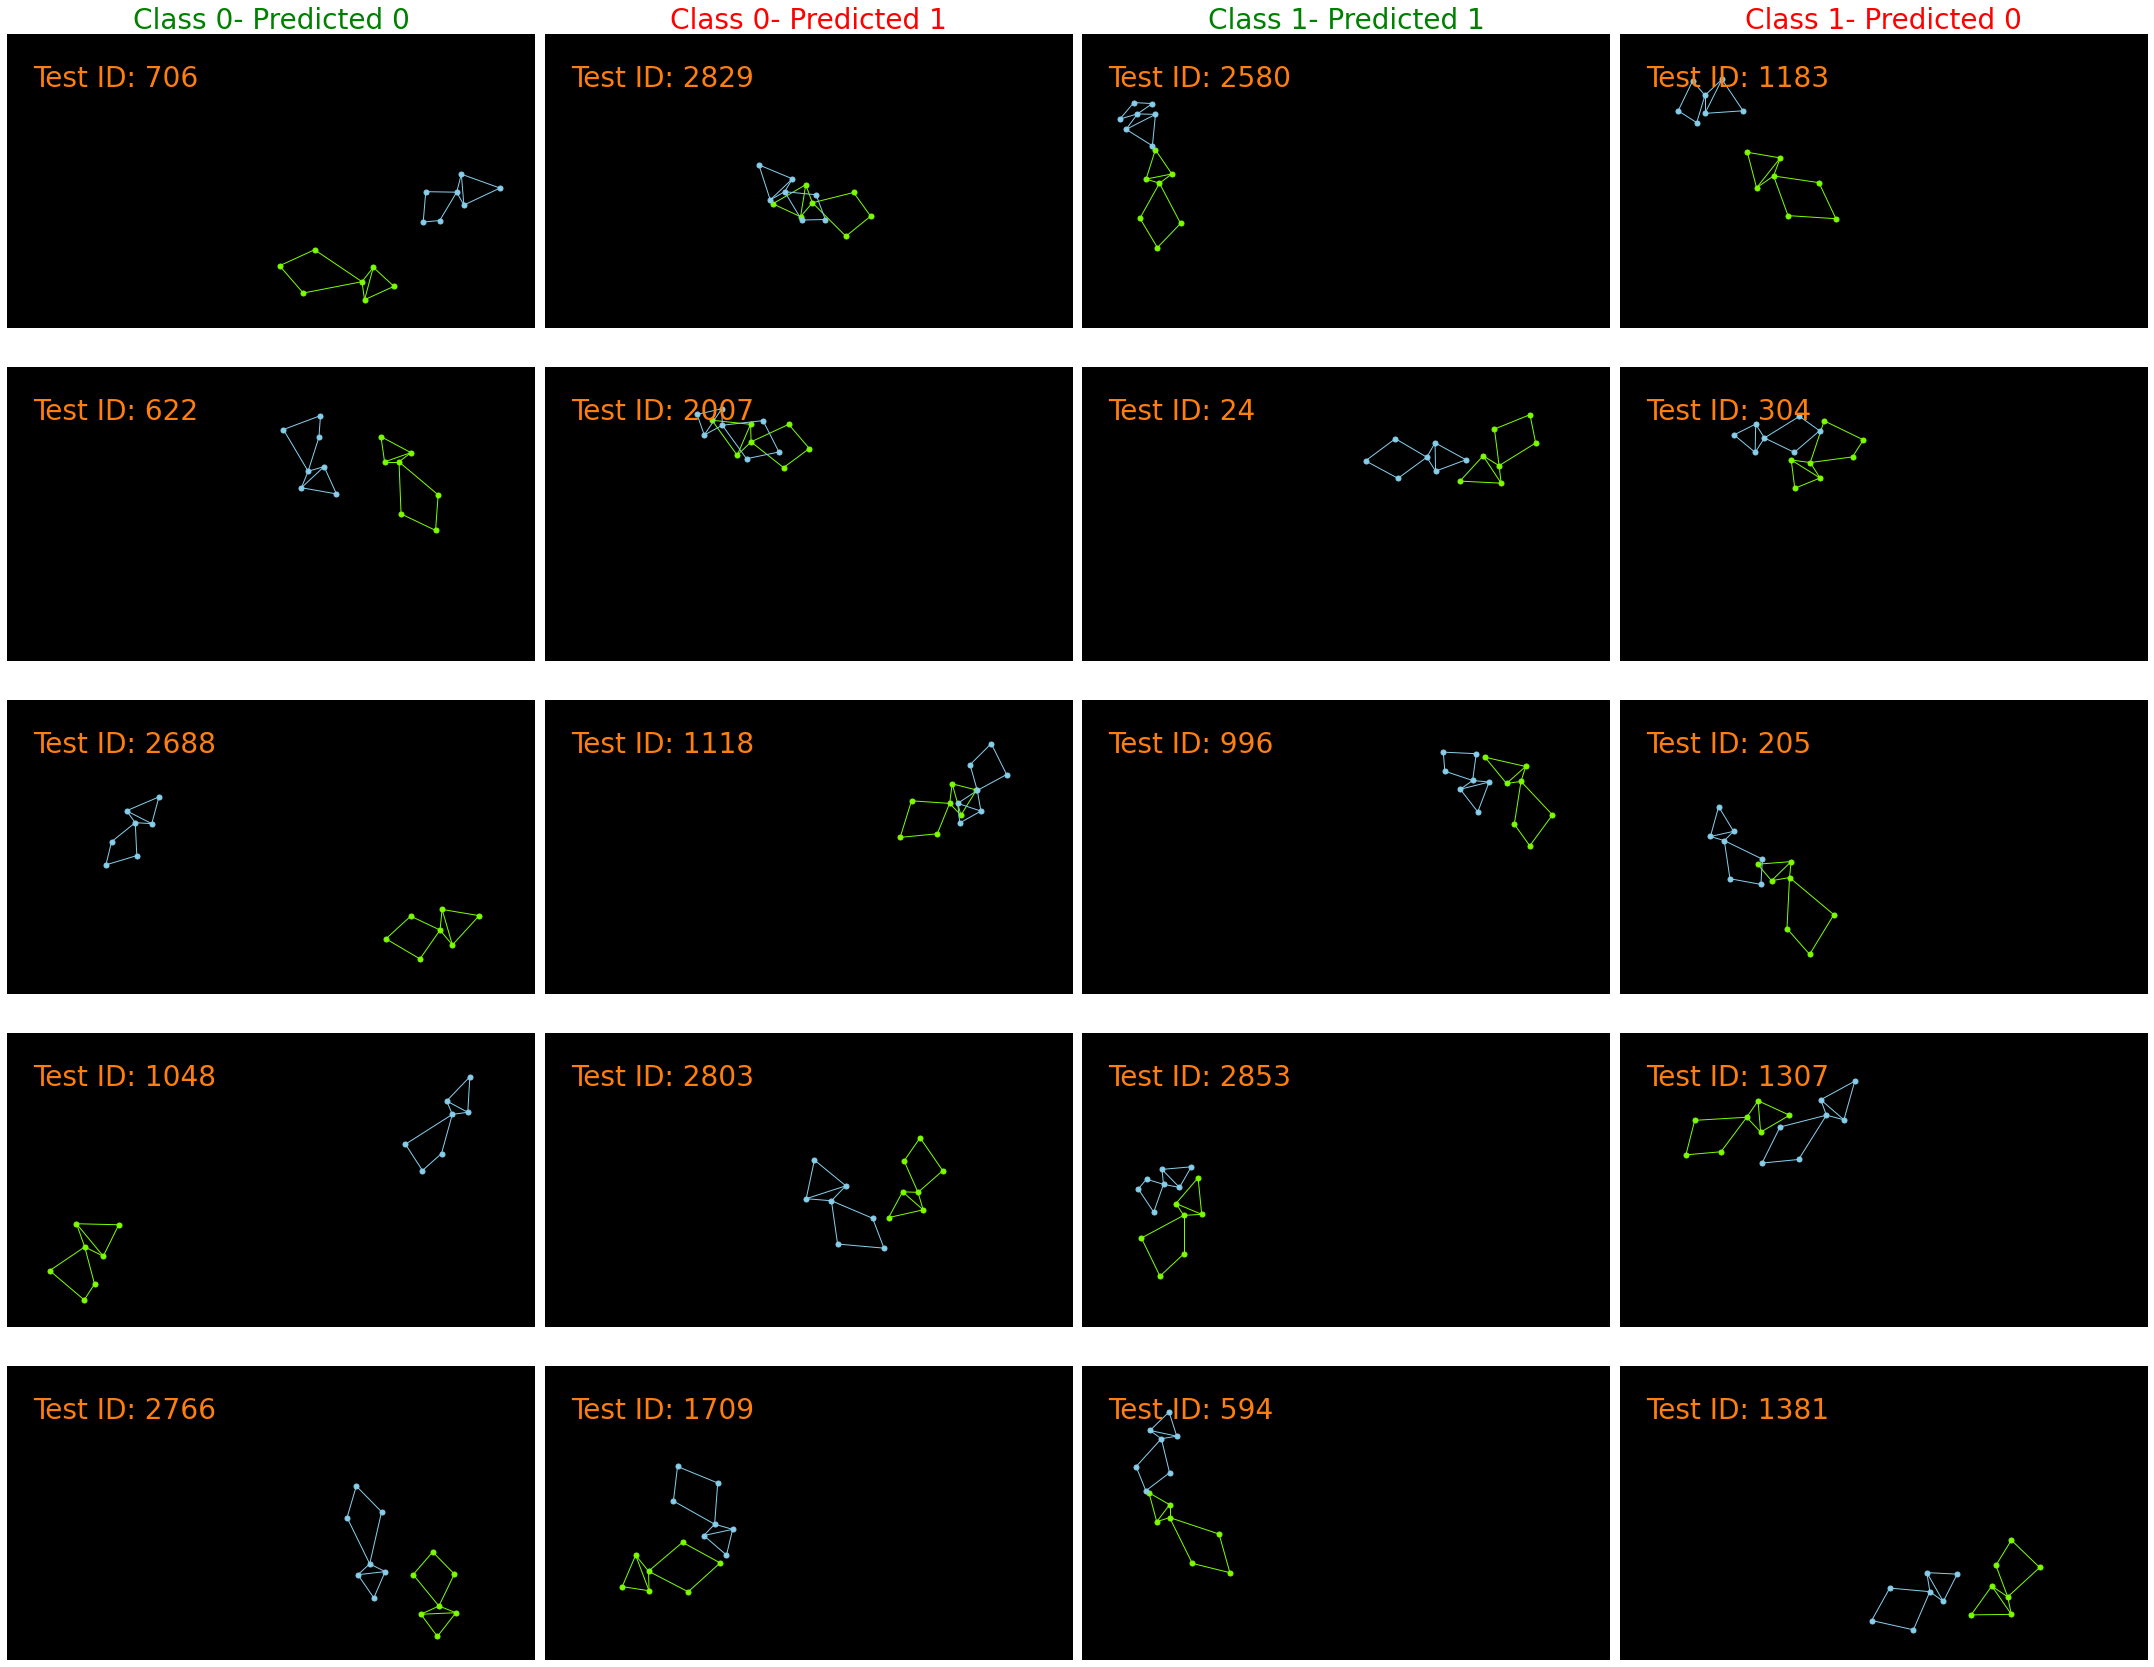

In [16]:
fig = display_samples_by_class(test_trajectory, test_labels, predictions_nn)
plt.show(fig)

# Program Optimization and DSL Example

Let's try to hand engineer program structures to solve this task! After specifying program structure, we update program parameters using gradient descent and Pytorch. This is possible because our programs are differentiable. We'll be writing programs in the language specified below:

Selectors (`atom -> atom`): 
* `ResAngleHeadBodySelect`: angle formed by the left/right ear, neck and left/right hip keypoints on the resident mouse.
* `SpeedSelect`: mean change in position of centroids, computed across two consecutive frames for resident and intruder moouse.
* `TangentialVelocitySelect`: component of the mouse’s centroid velocity tangential to the vector between the centroids of the two mice, computed across two consecutive frames, for resident and intruder mouse.
* `AccelerationSelect`: mean change in speed of centroids computed across two consecutive frames for resident and intruder mouse.
* `RelAngleSocialSelect`: relative angle between the body of the mouse (ori_body) and the line connecting the centroids of both mice, computed for resident and intruder mouse. 
* `AxisRatioSelect`:	major_axis_len/minor_axis_len of an ellipse fit to the pose of each mice.
* `OverlapBboxesSelect`: intersection over union of the bounding boxes of the two mice.	
* `MinResNoseKeypointDistSelect`: The minimum over all distances from the resident nose to any intruder keypoints.

Operators (`atom -> atom`):
* `Or(fn1, fn2)` : Adding output logits from two programs.
* `And(fn1, fn2)` : Multiplying output logits from two programs.

Aggregators (`List[atom] -> atom`):
* `Window5Avg` : `current_prediction = avg(pred[i-2:i]+ pred[i] + pred[i:i+2])`
* `Window7Avg` : `current_prediction = avg(pred[i-3:i]+ pred[i] + pred[i:i+3])`
* `Window13Avg` : `current_prediction = avg(pred[i-6:i]+ pred[i] + pred[i:i+6])`


Sample program:

`Window5Avg( Or(AccelerationSelect, OverlapBboxesSelect) )` will calculate the acceleration and the bounding box overlap of the resident and intruder mice and use the running average across 5 frames in the input to predict whether the resident mouse is investigating or not. In general, the innermost functions are executed first and are used as inputs to the outer functions.

**Note**: The `program` parser is very primitive and does not account for trailing commas or special characters! 

In [17]:
from dsl_compiler import ExpertProgram

program = "Window5Avg( Or(AccelerationSelect, OverlapBboxesSelect) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
# Evaluate using F1 score.

predictions_nn, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

F1 score on test set: 0.30218068535825543
Precision on test set: 0.34397163120567376
Recall on test set: 0.26944444444444443


**Exercise**: Can you find feature combinations that work better than the sample program? How does your hand-crafted program compare to the 1D Conv Net in terms of F1 score?

**Hint**: Based on the trajectory visualizations with features above, is there a feature that can discriminate between investigation and no investigation better than the provided sample program? 

In [ ]:
program = '### Your Program Here ###'
config.lr = 1e-2
expert_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
custom_model = train(expert_model, dm, config=config)

predictions_nn, _, _, _ = evaluate(custom_model, dm.test_dataloader(), test_labels)

# Visualizing 1D Conv Net and Programs 

**Exercise**: We visualize the weights of part of the 1D Conv Net as well as from the optimized programs. How does the number of parameters compare from neural nets such as 1D Conv Nets to programs?


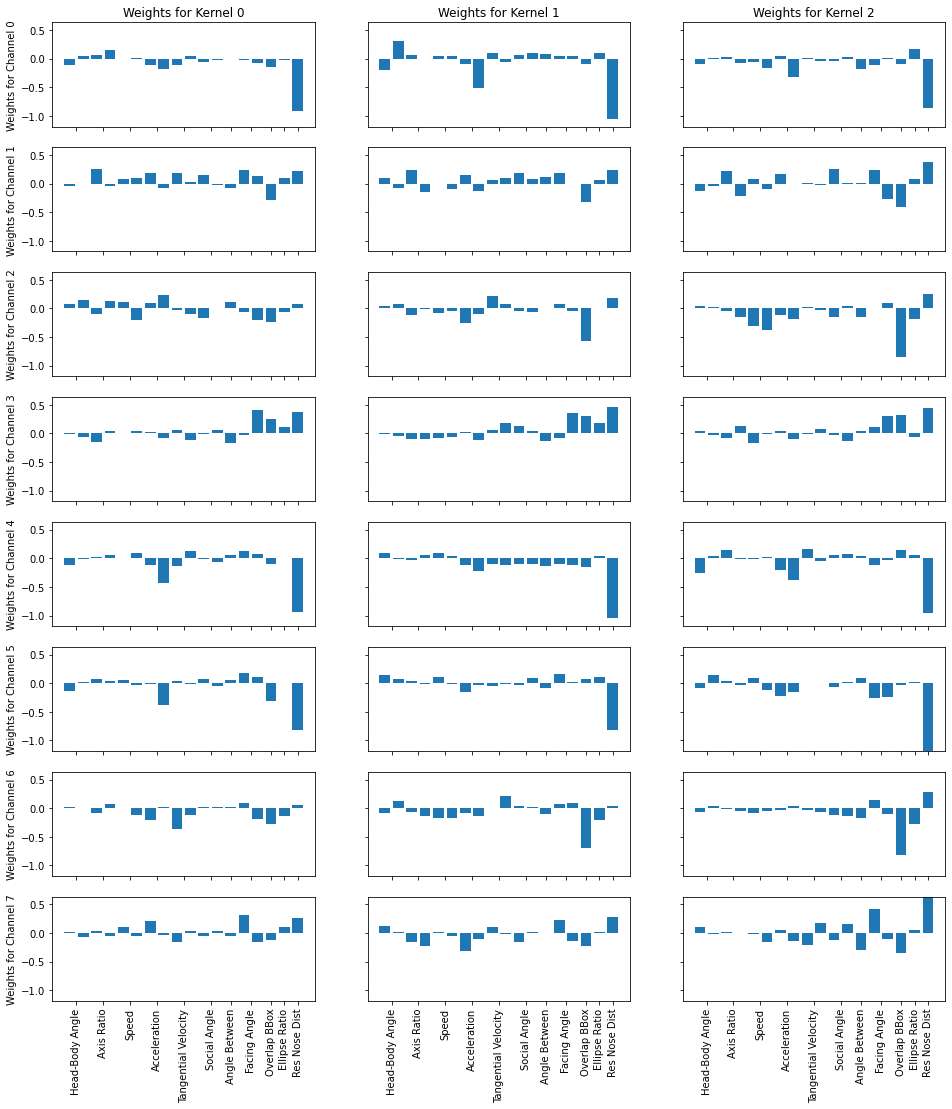

In [19]:
layer_to_plot = 'block1.conv.weight' # We plot one of the conv layers

for name, param in trained_model.model.named_parameters():
  if name == layer_to_plot:
    param = param.detach().numpy()
    num_channels, num_features, num_kernels = param.shape

    max_val = np.max(param)
    min_val = np.min(param)    
    
    fig, axs = plt.subplots(num_channels, num_kernels, 
                            figsize = (num_channels*2, num_kernels*6), 
                            sharex = True, sharey = True)
    
    for i in range(num_channels):
      axs[i][0].set_ylabel('Weights for Channel ' + str(i))

      for j in range(num_kernels):
        axs[i][j].bar(range(num_features), param[i, :, j])
        axs[i][j].set_ylim([min_val, max_val])

    for j in range(num_kernels):
      axs[0][j].set_title('Weights for Kernel ' + str(j))
      axs[-1][j].set_xticks([0.5,2.5,4.5,6.5,8.5,10.5,12,13.5,15,16, 17])
      axs[-1][j].set_xticklabels(["Head-Body Angle", "Axis Ratio", "Speed",
                                  "Acceleration", "Tangential Velocity", 
                                  "Social Angle", "Angle Between", "Facing Angle",
                                  "Overlap BBox", "Ellipse Ratio", "Res Nose Dist"],
                                 rotation = 90) 
      


In [20]:
# Print program
from near import print_program

print(print_program(sample_model.model, ignore_constants = False))


Window5Avg(Or(AccelerationSelect(params: dict_values([Parameter containing:
tensor([[-0.0328,  0.2786],
        [-0.3292,  0.0823]], requires_grad=True), Parameter containing:
tensor([ 0.4475, -0.6127], requires_grad=True)])), OverlapBboxesSelect(params: dict_values([Parameter containing:
tensor([[-0.5184],
        [ 0.6506]], requires_grad=True), Parameter containing:
tensor([-0.0506, -0.1254], requires_grad=True)]))))


# [Optional] Open-Ended Exploration

Can you improve the performance of the 1D Conv Net or your own hand-designed programs?

*     Try modifying `TrainConfig` above or any other part of the 1D Conv Net architecture in `ConvNet1DBaseline` to see if you can improve the performance of the 1D Conv Net!
*     Try improving your own program within the provided DSL and see how your optimized programs compare to the 1D Conv Net performance! How do different program architecture choices affect performance?

Over the next few days, we will show you ways of automatically performing program architecture search from the DSL without manually designing program structures as we do in this notebook.

**Acknowledgements**: This notebook was developed by Jennifer J. Sun  (Caltech) and Atharva Sengal (UT Austin) for [the neurosymbolic summer school](http://www.neurosymbolic.org/summerschool.html). The data subset is processed from CalMS21 and the DSL is developed by by Megan Tjandrasuwita (MIT) from her work on [Interpreting Expert Annotation Differences in Animal Behavior](https://arxiv.org/pdf/2106.06114.pdf). 